# Fault Diagnosis of Gear

In [6]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

![](https://therustyfox.com/wp-content/uploads/2019/02/IMG_0301-1024x771.jpg)

![Drag Racing](https://www.mikipulley.co.jp/en/services/tech_data/img/tech_img41.png)

## Dataset (https://www.kaggle.com/brjapon/gearbox-fault-diagnosis)

# Import and scale the data

In [7]:
df  = pd.read_csv('Gear_Fault_data.csv')

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df.iloc[:,:-2]=scaler.fit_transform(df.iloc[:,:-2])

df

,a1,a2,a3,a4,load,fault
0,0.381468,0.329958,-0.421759,-0.460352,0.0,F
1,0.398126,0.317534,-0.713949,0.220273,0.0,F
2,-0.039401,-0.060712,0.199101,0.135505,0.0,F
3,0.183330,-0.202151,0.174735,0.137119,0.0,F
4,-0.210701,0.222349,-0.286385,-0.077817,0.0,F
...,...,...,...,...,...,...
2021114,0.109795,-0.733740,-0.436623,-0.703804,0.9,H
2021115,-1.717584,1.752341,-0.552190,0.575163,0.9,H
2021116,-0.655194,0.584480,0.369389,0.610819,0.9,H
2021117,0.303240,-1.154518,1.346836,-0.305877,0.9,H


In [8]:
df

,a1,a2,a3,a4,load,fault
0,0.381468,0.329958,-0.421759,-0.460352,0.0,F
1,0.398126,0.317534,-0.713949,0.220273,0.0,F
2,-0.039401,-0.060712,0.199101,0.135505,0.0,F
3,0.183330,-0.202151,0.174735,0.137119,0.0,F
4,-0.210701,0.222349,-0.286385,-0.077817,0.0,F
...,...,...,...,...,...,...
2021114,0.109795,-0.733740,-0.436623,-0.703804,0.9,H
2021115,-1.717584,1.752341,-0.552190,0.575163,0.9,H
2021116,-0.655194,0.584480,0.369389,0.610819,0.9,H
2021117,0.303240,-1.154518,1.346836,-0.305877,0.9,H


# Making the dataset with window length for CNN

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [29]:
win_len=100
stride=200

X=[]
Y=[]


for k in ['F','H']:
    
    df_temp_1 = df[df['fault']==k]
    
    for j in (np.arange(0,1,0.1)):
        df_temp_2=df_temp_1[df_temp_1['load']==j]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            X.append(df_temp_2.iloc[i:i+win_len,:-1])
            Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [30]:
X.shape

(7138, 100, 5, 1)

# T-sne dimensionality reduction before CNN

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7138 samples in 0.000s...
[t-SNE] Computed neighbors for 7138 samples in 1.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7138
[t-SNE] Computed conditional probabilities for sample 2000 / 7138
[t-SNE] Computed conditional probabilities for sample 3000 / 7138
[t-SNE] Computed conditional probabilities for sample 4000 / 7138
[t-SNE] Computed conditional probabilities for sample 5000 / 7138
[t-SNE] Computed conditional probabilities for sample 6000 / 7138
[t-SNE] Computed conditional probabilities for sample 7000 / 7138
[t-SNE] Computed conditional probabilities for sample 7138 / 7138
[t-SNE] Mean sigma: 4.793280
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.133766
[t-SNE] KL divergence after 300 iterations: 3.777743


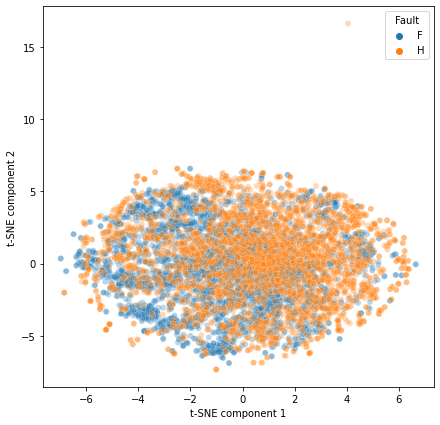

In [31]:
X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

# CNN Model

In [18]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = 2

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(20, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))

cnn_model.add(MaxPooling2D((20, 2),strides=(5, 5),padding='same'))

cnn_model.add(Conv2D(64, (10, 3), activation='relu',padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(10, 2),strides=(3, 3),padding='same'))

# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))
                 
# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
         

cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 5, 32)        1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 1, 64)         61504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               57472     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [19]:
batch_size = 128
epochs = 5
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/5
40/40 [==============================] - 3s 75ms/step - loss: 0.1839 - accuracy: 0.9197 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 2/5
40/40 [==============================] - 3s 65ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 4.3768e-04 - val_accuracy: 1.0000
Epoch 3/5
40/40 [==============================] - 3s 66ms/step - loss: 4.1905e-04 - accuracy: 1.0000 - val_loss: 3.0888e-04 - val_accuracy: 1.0000
Epoch 4/5
40/40 [==============================] - 3s 64ms/step - loss: 2.1935e-04 - accuracy: 1.0000 - val_loss: 1.6983e-04 - val_accuracy: 1.0000
Epoch 5/5
40/40 [==============================] - 3s 67ms/step - loss: 1.4563e-04 - accuracy: 1.0000 - val_loss: 1.0126e-04 - val_accuracy: 1.0000


In [20]:
cnn_model.save(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')

# Performance of the proposed model

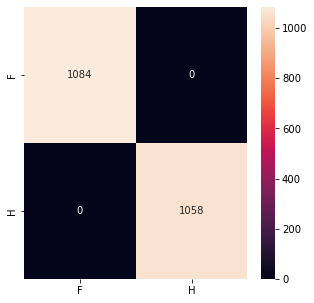

In [21]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(5,5))
cm = confusion_matrix(Y_test, Y_pred)
f = sns.heatmap(cm, annot=True, fmt='d',xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

# Visualize the output

In [22]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)

In [24]:
y_viz.shape

(4996, 128)

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4996 samples in 0.001s...
[t-SNE] Computed neighbors for 4996 samples in 1.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4996
[t-SNE] Computed conditional probabilities for sample 2000 / 4996
[t-SNE] Computed conditional probabilities for sample 3000 / 4996
[t-SNE] Computed conditional probabilities for sample 4000 / 4996
[t-SNE] Computed conditional probabilities for sample 4996 / 4996
[t-SNE] Mean sigma: 0.438167
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.863129
[t-SNE] KL divergence after 300 iterations: 1.734102


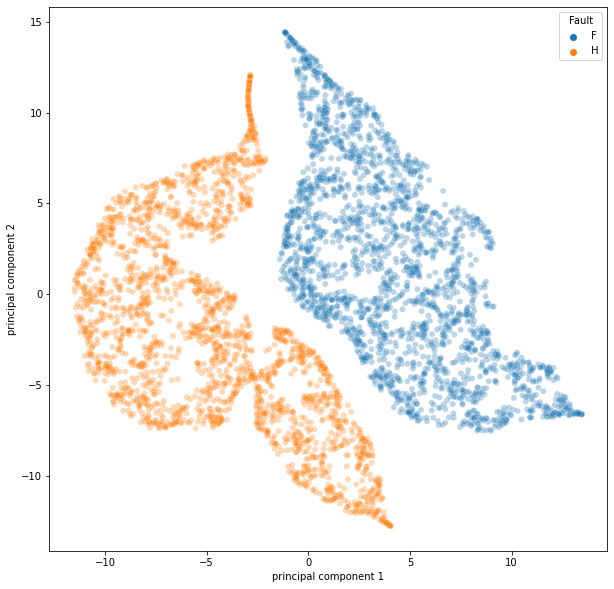

In [25]:

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['principal component 1', 'principal component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['principal component 1'],y=tSNEdf['principal component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

# Flatten Layer

C:\Users\mohan\.conda\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4996 samples in 0.000s...
[t-SNE] Computed neighbors for 4996 samples in 0.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4996
[t-SNE] Computed conditional probabilities for sample 2000 / 4996
[t-SNE] Computed conditional probabilities for sample 3000 / 4996
[t-SNE] Computed conditional probabilities for sample 4000 / 4996
[t-SNE] Computed conditional probabilities for sample 4996 / 4996
[t-SNE] Mean sigma: 0.768952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.100151
[t-SNE] KL divergence after 300 iterations: 1.953991


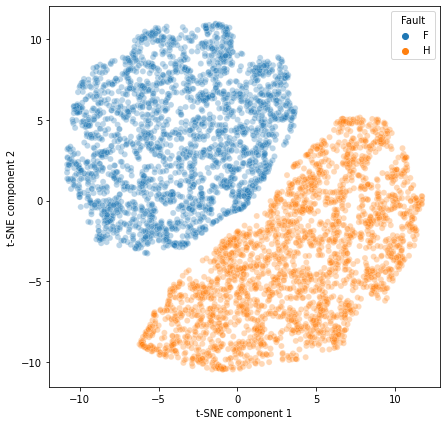

In [27]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[4].output)
y_viz = dummy_cnn.predict(X_train)








from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()